# setup

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from datasets import load_dataset
from utils import transform, collate_fn, model_select

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
BATCH_SIZE = 1024

# data

In [3]:
# H_rn18 = torch.load('output/rn18_H_val.pt')[:, :, 0, 0]
H_rn34 = torch.load('output/rn34_H_val.pt')[:, :, 0, 0]

In [10]:
model = torch.load('output/rn18_mirror_rn34.pt')
model = model.to(device)

In [13]:
val = load_dataset("evanarlian/imagenet_1k_resized_256", split = 'val')

val = val.with_transform(transform)
val_loader = torch.utils.data.DataLoader(val, collate_fn = collate_fn, batch_size = BATCH_SIZE)
val.num_rows / BATCH_SIZE

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

48.828125

In [14]:
H_rn18 = torch.empty(size = [0])

model.eval()
with torch.no_grad():
    for i, sample in tqdm(enumerate(val_loader)):
        x = sample['image'].to(device)
        h = model.forward(x)

        H_rn18 = torch.cat((H_rn18, h.cpu()))

49it [01:34,  1.93s/it]


In [16]:
H_rn18 = H_rn18[:, :, 0, 0]

# mse

In [17]:
H_rn18.shape, H_rn34.shape

(torch.Size([50000, 512]), torch.Size([50000, 512]))

In [18]:
loss = torch.nn.MSELoss(reduction = 'none')

mse = loss(H_rn18, H_rn34)

In [19]:
delta = torch.sum(mse, dim = 1)
torch.mean(delta)

tensor(164.5263)

In [20]:
delta

tensor([193.1370, 161.7753, 196.0904,  ...,  99.6512,  97.1987, 188.6466])

In [21]:
delta.shape[0]

50000

In [22]:
delta[0] / torch.linalg.vector_norm(H_rn34[0])

tensor(6.3022)

In [23]:
norm = [torch.linalg.vector_norm(H_rn34[i]) for i in range(delta.shape[0])]
percentual = delta / torch.Tensor(norm)

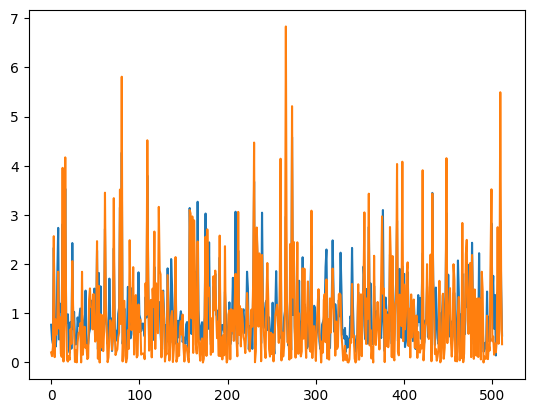

In [24]:
plt.plot(H_rn18[0]);
plt.plot(H_rn34[0]);

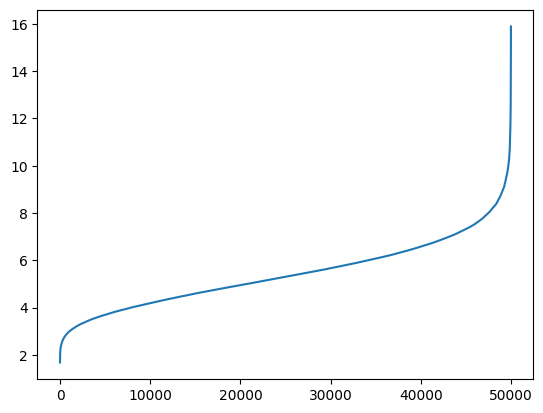

In [25]:
plt.plot(np.sort(percentual));

# sim

In [26]:
N = 100
sample = np.random.choice(H_rn18.shape[0], N)
h_rn18 = H_rn18[sample, :]
h_rn34 = H_rn34[sample, :]

In [27]:
h_rn18 /= h_rn18.norm(dim=-1, keepdim=True)
h_rn34 /= h_rn34.norm(dim=-1, keepdim=True)
similarity = h_rn18.numpy() @ h_rn34.numpy().T

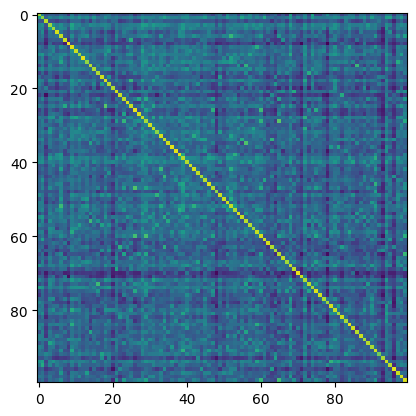

In [28]:
plt.imshow(similarity);